In [1]:
import os 
import pandas as pd
import splitfolders
import cv2

In [2]:
image_path = 'dataset/47194.jpg'
img = cv2.imread(image_path)
img.shape

(256, 256, 3)

In [3]:
image_path = 'dataset/49108.jpg'
img = cv2.imread(image_path)
img.shape

(256, 256, 3)

In [4]:
from sklearn.model_selection import train_test_split

i have my data in one folder so i split it into train and test 

In [5]:
def split_dataset(dataset_dir, test_size=0.2, random_state=42):
  file_paths = []
  for root, _, files in os.walk(dataset_dir):
    for file in files:
      file_path = os.path.join(root, file)
      file_paths.append(file_path)

  train_files, test_files = train_test_split(file_paths, test_size=test_size, random_state=random_state)
  return train_files, test_files

dataset_dir = "dataset"
train_dir, test_dir = split_dataset(dataset_dir)

In [6]:
len(train_dir)

800

In [7]:
len(test_dir)

201

# preparing the data

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

here i change the size of the images and do some preprocess on the data

In [9]:
def load_and_preprocess_images(file_paths, target_size=(64, 64)):
    images = []
    for file_path in file_paths:
        img = load_img(file_path, target_size=target_size)  # Load image and resize
        img_array = img_to_array(img)  # Convert to NumPy array
        images.append(img_array)
    images = np.array(images).astype('float32') / 255.  # Normalize to [0, 1]
    return images

In [10]:
x_train = load_and_preprocess_images(train_dir)
x_test = load_and_preprocess_images(test_dir)

print(x_train.shape)
print(x_test.shape)

(800, 64, 64, 3)
(201, 64, 64, 3)


In [11]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Print shapes
print(x_train.shape)
print(x_test.shape)

(800, 12288)
(201, 12288)


# Start implementing VAE

In [12]:
import keras
from keras import layers
import numpy as np

In [22]:
original_dim = 12288
intermediate_dim = 64
latent_dim = 10

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)

z_log_sigma = layers.Dense(latent_dim)(h)
print(z_mean.shape)

(None, 10)


In [14]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
    return z_mean + tf.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [31]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 12288)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 64)                │         786,496 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 10)                │             650 │ dense_5[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 10)                │             650 │ dense_5[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_4 (Lambda)             │ (None, 10)                │               0 │ dense_6[0][0],             │
│                               │                           │                 │ dense_7[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 787,796 (3.01 MB)

 Trainable params: 787,796 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim

class KLLossLayer(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_sigma = inputs
        kl_loss = 1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma)
        kl_loss = tf.reduce_sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        return kl_loss

# Assuming z_mean and z_log_sigma are your inputs
kl_loss_layer = KLLossLayer()([z_mean, z_log_sigma])

In [33]:
vae.compile(optimizer='adam', loss='binary_crossentropy')
vae.fit(x_train, x_train,
        epochs=2,
        batch_size=32)

Epoch 1/2
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.6875
Epoch 2/2
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.6706


In [34]:
x_decoded = vae.predict(x_train)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


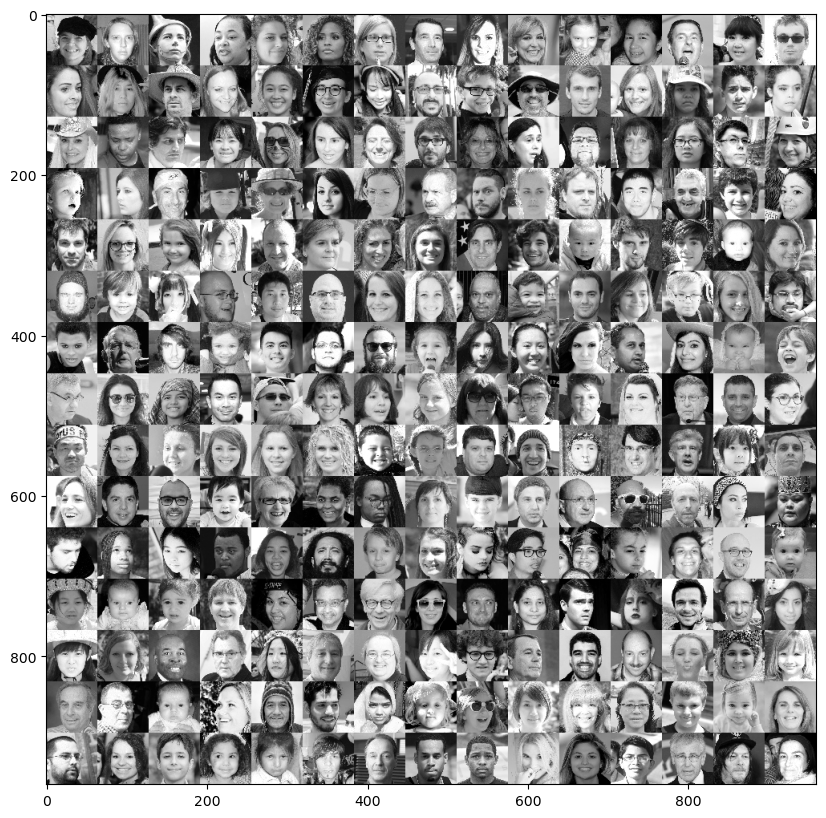

225


In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 64
num_channels = 3  # Assuming RGB images
figure = np.zeros((digit_size * n, digit_size * n, num_channels))

# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k = 0

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        # x_decoded = decoder.predict(z_sample)
        digit = x_train[k].reshape(digit_size, digit_size, num_channels)
        k += 1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure[:, :, 0], cmap='gray')  # Display only one channel for grayscale
plt.show()

print(k)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

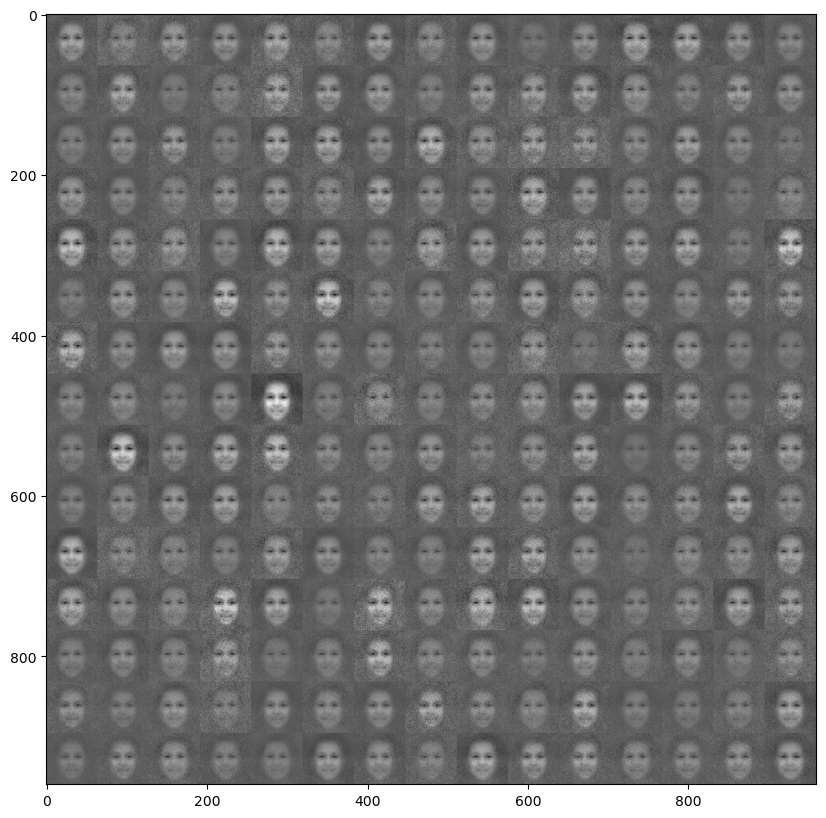

225


In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 64
num_channels = 3  # Assuming RGB images
figure = np.zeros((digit_size * n, digit_size * n, num_channels))

# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k = 0

latent_dim = 10  # This should match the latent dimension used in your VAE

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.random.normal(size=(1, latent_dim))  # Sample from the latent space
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size, num_channels)
        k += 1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure[:, :, 0], cmap='gray')  # Display only one channel for grayscale
plt.show()

print(k)

# better shape approach

## preparing the data

In [70]:
x_train = load_and_preprocess_images(train_dir)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
print(x_train.shape)

(800, 12288)


In [71]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
    return z_mean + tf.exp(z_log_sigma) * epsilon

In [72]:
###########################################################################################################################
### AutoEncoder
#encoding_dim = 128  

#input_img = keras.Input(shape=(49152,))
#encoded = layers.Dense(1024, activation='relu')(input_img)
#encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

## endcoder
#encoder = keras.Model(input_img, encoded)

#encoded_input = keras.Input(shape=(encoding_dim,))
#decoded = layers.Dense(1024, activation='relu')(encoded_input)
#decoded = layers.Dense(49152, activation='sigmoid')(decoded)

## decoder
#decoder = keras.Model(encoded_input, decoded)

#autoencoder = keras.Model(input_img, decoder(encoder(input_img)))
#################################################################################################################################
original_dim = 12288
latent_dim = 128

# Encoder parts
inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(1024, activation='relu')(inputs)

z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# decoder parts
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(1024, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)

# Create decoder
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 12288)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_27 (Dense)              │ (None, 1024)              │      12,583,936 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_28 (Dense)              │ (None, 128)               │         131,200 │ dense_27[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_29 (Dense)              │ (None, 128)               │         131,200 │ dense_27[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_8 (Lambda)             │ (None, 128)               │               0 │ dense_28[0][0],            │
│                               │                           │                 │ dense_29[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 12,846,336 (49.00 MB)

 Trainable params: 12,846,336 (49.00 MB)

 Non-trainable params: 0 (0.00 B)

## loss function

In [73]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
# Assuming z_mean and z_log_sigma are your inputs
kl_loss_layer = KLLossLayer()([z_mean, z_log_sigma])

## complining and running VAE Model

In [74]:
vae.compile(optimizer='adam', loss='binary_crossentropy')
vae.fit(x_train, x_train,
        epochs=20,
        batch_size=32)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 254ms/step - loss: 1.3970
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - loss: 0.6762
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 270ms/step - loss: 0.6617
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 257ms/step - loss: 0.6557
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - loss: 0.6505
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - loss: 0.6501
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - loss: 0.6487
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - loss: 0.6450
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - loss: 0.6462
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 259ms/step - loss: 0.6430
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 257ms/step - loss: 0.6459
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - loss: 0.6444
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - loss: 0.6457
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - loss: 0.6429
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - lo

In [75]:
x_decoded = vae.predict(x_train)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [55]:
print("Original shape of x_test:", x_train.shape)

Original shape of x_test: (800, 12288)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━

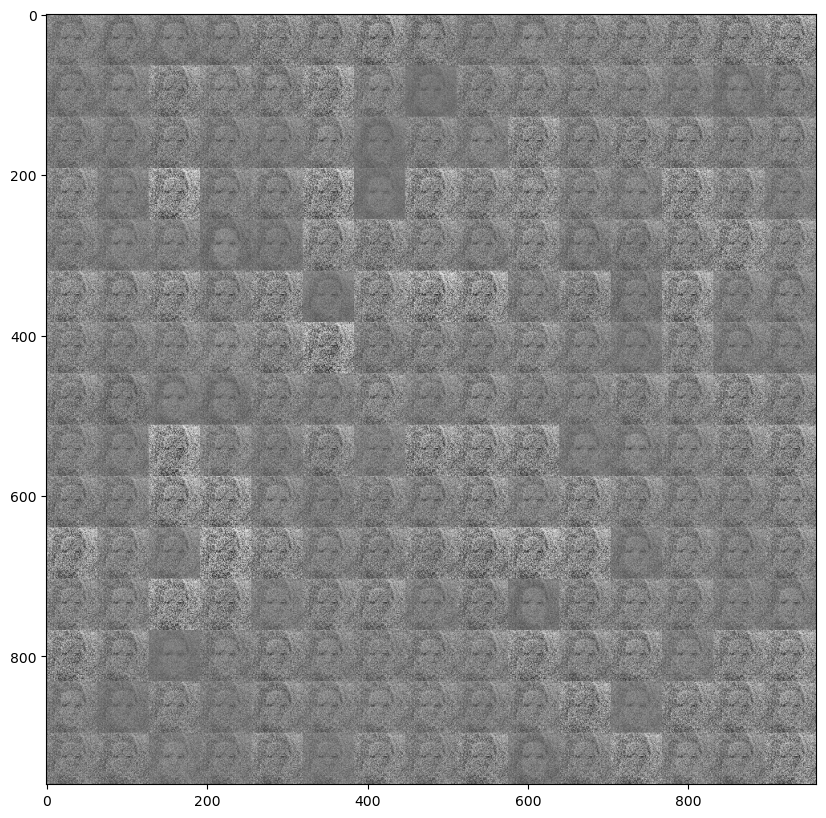

225


In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 64
num_channels = 3  
figure = np.zeros((digit_size * n, digit_size * n, num_channels))

# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k = 0

latent_dim = 128  

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.random.normal(size=(1, latent_dim))  # Sample from the latent space
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size, num_channels)
        k += 1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure[:, :, 0], cmap='gray')  # Display only one channel for grayscale
plt.show()

print(k)

In [81]:
print("x_train shape:", x_train.shape)
print("x_decoded shape:", x_decoded.shape)

x_train shape: (800, 64, 64, 3)
x_decoded shape: (800, 12288)


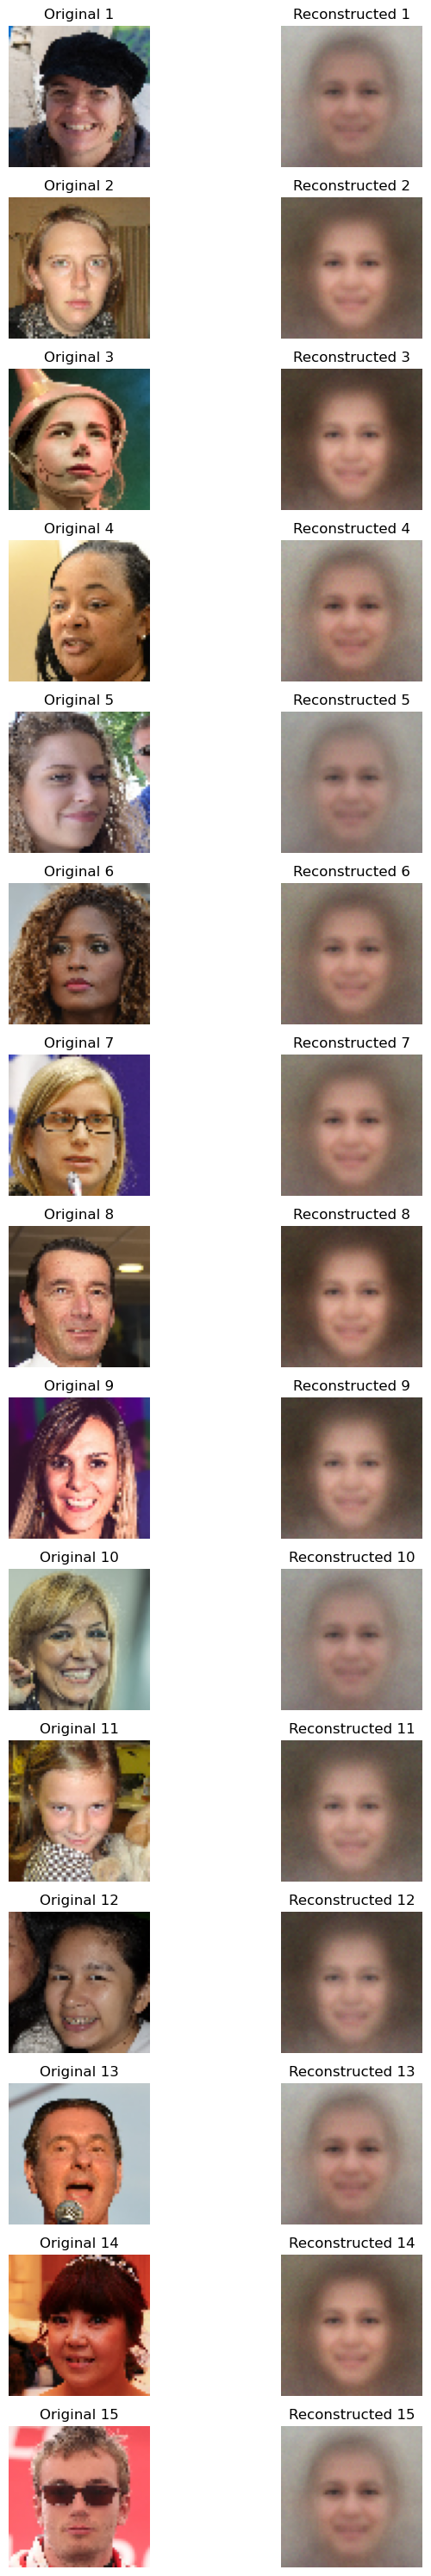

In [77]:
import matplotlib.pyplot as plt

# Reshape the flattened images back to their original dimensions (64, 64, 3)
x_train_reshaped = x_train.reshape(-1, 64, 64, 3)
x_decoded_reshaped = x_decoded.reshape(-1, 64, 64, 3)

# Select the first 15 images for visualization
num_images = 15
fig, axes = plt.subplots(num_images, 2, figsize=(8, 30))

for i in range(num_images):
    # Original image
    axes[i, 0].imshow(x_train_reshaped[i])
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Original {i+1}")
    
    # Reconstructed image
    axes[i, 1].imshow(x_decoded_reshaped[i])
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Reconstructed {i+1}")

plt.tight_layout()
plt.show()

In [12]:
x_train = load_and_preprocess_images(train_dir) # X_train original shape (800, 64, 64, 3)
print(x_train.shape)

(800, 64, 64, 3)


In [13]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
    return z_mean + tf.exp(z_log_sigma) * epsilon

# Actual VAE cnn model

In [14]:
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Layer
import tensorflow as tf
from tensorflow.keras import backend as K

this cell hepled us overcome a problem in loss function that appears while we tring to apply VAE CNN architecture 

In [15]:
# Define the custom VAE Layer
class VAE(Layer):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        # Get the mean, log_sigma, and z from the encoder
        z_mean, z_log_sigma, z = self.encoder(inputs)
        
        # Decode the latent vector to reconstruct the image
        reconstructed_image = self.decoder(z)
        
        # Add the KL divergence loss to the model's total loss
        kl_loss = -0.5 * K.mean(K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=1))
        self.add_loss(kl_loss)
        
        return reconstructed_image

In [16]:
# Define the encoder as before
original_dim = (64, 64, 3)
latent_dim = 128

inputs = tf.keras.Input(shape=original_dim, name='encoder_input')
x = layers.Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(inputs)
x = layers.Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)

z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_sigma = layers.Dense(latent_dim, name='z_log_sigma')(x)

z = layers.Lambda(sampling, name='z')([z_mean, z_log_sigma])

# Create encoder
encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Decoder parts
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(16 * 16 * 64, activation='relu')(latent_inputs)
x = layers.Reshape((16, 16, 64))(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
outputs = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

# Create decoder
decoder = Model(latent_inputs, outputs, name='decoder')

# Instantiate the VAE model
vae_output = VAE(encoder, decoder)(inputs)
vae = Model(inputs, vae_output, name='vae_cnn')

# Summaries of the models
encoder.summary()
decoder.summary()
vae.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)    │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 32, 32, 32)        │             896 │ encoder_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 16, 16, 64)        │          18,496 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 16384)             │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 256)               │       4,194,560 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z_mean (Dense)                │ (None, 128)               │          32,896 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z_log_sigma (Dense)           │ (None, 128)               │          32,896 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z (Lambda)                    │ (None, 128)               │               0 │ z_mean[0][0],              │
│                               │                           │                 │ z_log_sigma[0][0]          │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 4,279,744 (16.33 MB)

 Trainable params: 4,279,744 (16.33 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16384)               │       2,113,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,169,795 (8.28 MB)

 Trainable params: 2,169,795 (8.28 MB)

 Non-trainable params: 0 (0.00 B)

Model: "vae_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vae (VAE)                            │ (None, 64, 64, 3)           │       6,449,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,449,539 (24.60 MB)

 Trainable params: 6,449,539 (24.60 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# VAE loss function
def vae_loss(y_true, y_pred):
    # Reconstruction loss (binary crossentropy for images)
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(K.binary_crossentropy(y_true, y_pred), axis=(1, 2, 3)))
    return reconstruction_loss

# Compile the model with the custom VAE loss
vae.compile(optimizer='adam', loss=vae_loss)

In [18]:
# Training the VAE model
vae.fit(x_train, x_train, epochs=30, batch_size=32)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - loss: 8464.2002
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 8220.6318
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 7908.9331
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 7714.3906
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 7580.1646
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 7472.6504
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 7362.3398
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 7342.2505
Epoch 9/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 7322.9683
Epoch 10/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 7295.3013
Epoch 11/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 7283.0298
Epoch 12/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 7306.4678
Epoch 13/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 7301.2153
Epoch 14/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 7286.9512
Epoch 15/30
25/

In [19]:
x_decoded = vae.predict(x_train)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [20]:
print("x_train shape:", x_train.shape)
print("x_decoded shape:", x_decoded.shape)

x_train shape: (800, 64, 64, 3)
x_decoded shape: (800, 64, 64, 3)


## plotting original image and constructed image

In [21]:
import matplotlib.pyplot as plt

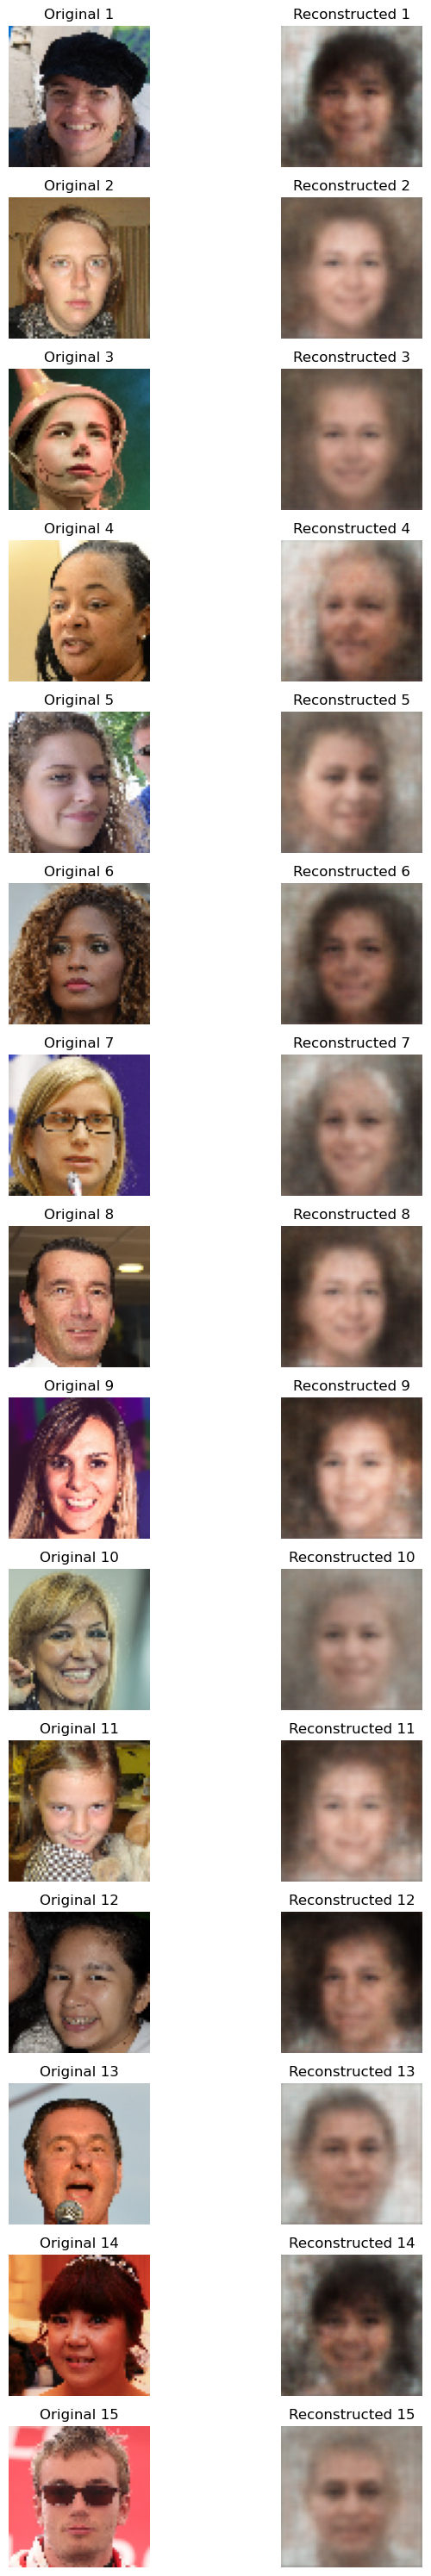

In [22]:
# Reshape the flattened images back to their original dimensions (64, 64, 3)
x_train_reshaped = x_train.reshape(-1, 64, 64, 3)
x_decoded_reshaped = x_decoded.reshape(-1, 64, 64, 3)

# Select the first 15 images for visualization
num_images = 15
fig, axes = plt.subplots(num_images, 2, figsize=(8, 30))

for i in range(num_images):
    # Original image
    axes[i, 0].imshow(x_train_reshaped[i])
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Original {i+1}")
    
    # Reconstructed image
    axes[i, 1].imshow(x_decoded_reshaped[i])
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Reconstructed {i+1}")

plt.tight_layout()
plt.show()

## generating new images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


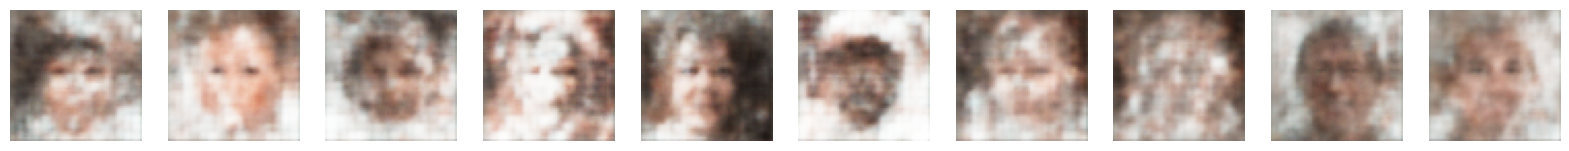

In [23]:
def sample_latent_vectors(latent_dim, num_samples=10):
    return np.random.normal(size=(num_samples, latent_dim))

# Generate random latent vectors
num_samples = 10  # Number of images to generate
latent_vectors = sample_latent_vectors(latent_dim, num_samples)

# Use the decoder to generate images from the latent vectors
generated_images = decoder.predict(latent_vectors)

# Plot the generated images
fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))
for i in range(num_samples):
    axes[i].imshow(generated_images[i])
    axes[i].axis('off')  # Hide axis

plt.show()

# choose number to display constructed images from vae model

In [24]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

### what we have done here 
- we have defined our slider widget
- then in generate random images function we generate new constructed images
- our range of generated images is from 1 to 30 and
    - we display from 1 to 10 images in row
    - then from 10 to 20 in another row
    - and from 20 to 30 in another row

In [25]:
# Create a slider widget
num_images_slider = widgets.IntSlider(
    value=5,  # Default value
    min=1,
    max=30,
    step=1,
    description='Number of Images:',
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

# Display the slider
display(num_images_slider)

# Create an output area for displaying images
output = widgets.Output()
display(output)

# Define the function to generate images
def generate_random_images(num_images):
    with output:
        clear_output(wait=True)  # Clear previous output immediately

        # Create a figure with multiple subplots
        rows = math.ceil(num_images / 10)
        cols = min(num_images, 10)  # Limit columns to avoid overflow
        figsize = (cols * 1.5, rows * 2)  # Adjust figure size dynamically
        fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
        fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Add spacing

        # Ensure axes is always 2D for consistent indexing
        if rows == 1:
            axes = np.array(axes).reshape(1, -1)

        latent_vectors = sample_latent_vectors(latent_dim, num_images)
        
        # Use the decoder to generate images from the latent vectors
        generated_images = decoder.predict(latent_vectors)

        for i in range(num_images):
            # Determine the subplot to use
            row = i // cols
            col = i % cols
    
            axes[row, col].imshow(generated_images[i], cmap='gray')
            axes[row, col].set_title(f'Image {i+1}')
            axes[row, col].axis('off')

        # Turn off unused axes
        for i in range(num_images, rows * cols):
            axes[i // cols, i % cols].axis('off')

        plt.show()

# Function to update the output based on slider value
def on_slider_change(change):
    generate_random_images(change['new'])

# Link the slider to the update function
num_images_slider.observe(on_slider_change, names='value')

# Initial call to generate images with default value
on_slider_change({'new': num_images_slider.value})

IntSlider(value=5, continuous_update=False, description='Number of Images:', max=30, min=1)

Output()

# in case if the cell doesn't work i have provided a samples from it 

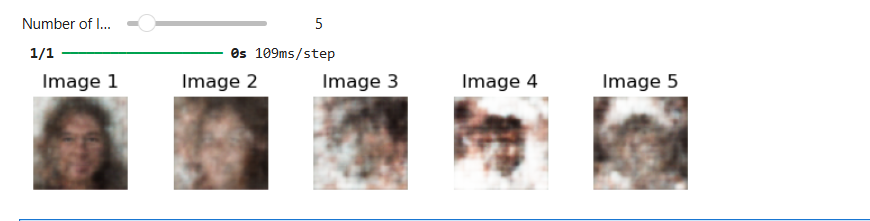

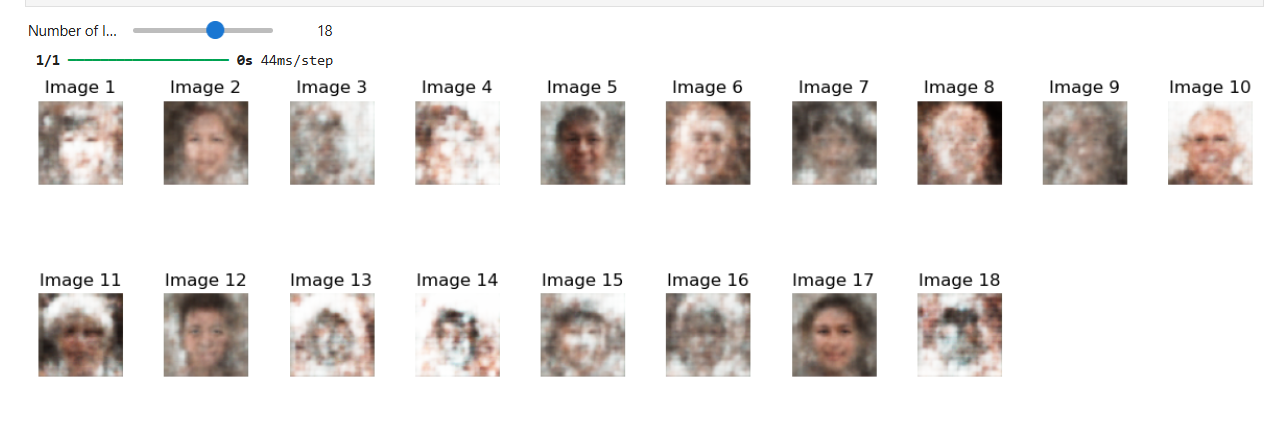

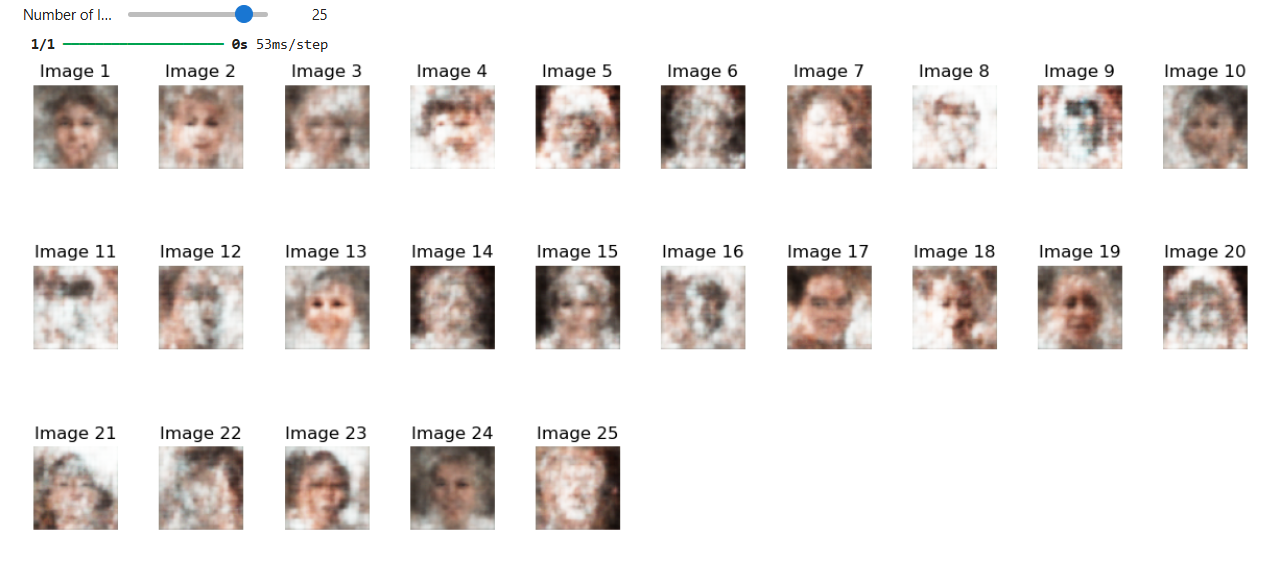

this assignment have been done by:

1- Mina Maged Faris        --    20210420

2- Filopater Maher Faris   --    20210291

3- abdullah el wazery      --    20200878

<p style="font-size:20px;"><b> finally thank you  </b></p>